# Check community outliers

In [7]:
# Load communities
commpath = '/data/tumblr_community_identity/dataset114k/louvain_communities.txt'
comms = {}
with open(commpath) as f:
    for i,line in enumerate(f.read().splitlines()):
        comms[i+1] = [int(tumblog_id) for tumblog_id in line.split()]
print(len(comms))

id2comm = {}
for n, comm in comms.items():
    for tumblog_id in comm:
        id2comm[tumblog_id] = n

82


## Plot communities

In [7]:
import plotly.express as px

comm_lens = {str(n): len(ids) for n, ids in comms.items()}
sorted_comms = sorted(comm_lens.items(), key=lambda x: x[1], reverse=True)[:30]
sorted_comms

[('59', 111205),
 ('6', 55514),
 ('49', 43234),
 ('3', 32602),
 ('22', 13910),
 ('11', 13182),
 ('63', 6763),
 ('42', 5072),
 ('10', 4960),
 ('7', 3698),
 ('5', 3485),
 ('2', 2999),
 ('4', 1656),
 ('17', 1508),
 ('15', 804),
 ('71', 287),
 ('1', 266),
 ('32', 265),
 ('20', 54),
 ('23', 32),
 ('67', 19),
 ('27', 17),
 ('51', 15),
 ('14', 12),
 ('19', 12),
 ('24', 11),
 ('25', 8),
 ('28', 6),
 ('54', 6),
 ('26', 5)]

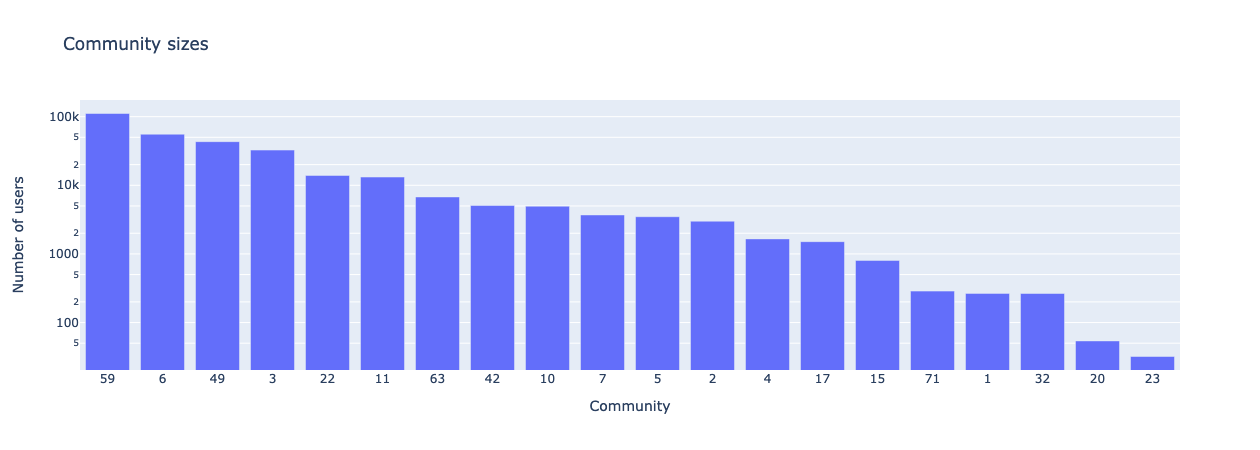

In [13]:
comm_nums, lens = list(zip(*sorted_comms[:20]))
px.bar(x=comm_nums, y=lens, log_y=True, title="Community sizes", labels=dict(x='Community', y='Number of users'))

## Get vectors for blog descriptions
Average word2vec embeddings

In [2]:
# Load blog descriptions
import pandas as pd
desc_path = '/data/tumblr_community_identity/dataset114k/blog_info_dataset114k.csv'
data = pd.read_csv(desc_path)
data

,tumblog_id,tumblr_blog_name,tumblr_blog_url,tumblr_blog_description,processed_tumblr_blog_description,tumblr_blog_title,language,created_time_epoch,is_primary,is_private,updated_time_epoch,post_count,is_group_blog,activity_time_epoch
0,165015715,goteambravo,http://goteambravo.tumblr.com/,<p>Ace/29/female/happily taken by galactic-kni...,ace/29/female/happily taken by galactic-knight...,Go! Go! Bravo!,en_US,1.389199e+12,True,false,1546211412000,NaN,False,1546211412
1,16189626,tomicen,https://tomicen.tumblr.com/,"Amy, 23, Sydney, Australia. ✨ Graphic design a...","amy , 23 , sydney , australia . ✨ graphic desi...",枚方生まれ、枚方育ち,en_US,1.301928e+12,False,false,1546224795000,NaN,False,1562581644
2,15711631,sparkle148,https://sparkle148.tumblr.com/,<p>I post a lot of TMNT and other garbage.</p>,i post a lot of tmnt and other garbage .,Pessimistic Procrastination,en_US,1.301189e+12,False,False,1543078924000.0,31420.0,False,1544982349
3,94232773,goddamnalientourists,http://goddamnalientourists.tumblr.com/,"Name's Lizzie, I'm 20, she/her, a huge sci-fi ...","name 's lizzie , i 'm 20 , she/her , a huge sc...",Sold My Soul To Wynonna Earp,en_US,1.361120e+12,False,false,1530044420000,NaN,False,1543260493
4,3003245,wherethepotterthingsare,https://wherethepotterthingsare.tumblr.com/,"kendra, 22, canada","kendra , 22 , canada",just a face and a name,en_US,1.263865e+12,False,false,1545681604000,NaN,False,1565400429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294248,177356292,ceranimoo,https://ceranimoo.tumblr.com/,<p>ig/anlakbulat</p>,ig/anlakbulat,Anıl,tr_TR,1.395695e+12,False,false,1536688976000,715.0,False,1545951611
294249,27783944,totescrepe,https://totescrepe.tumblr.com/,My name is Kayla and I am a french pancake.,my name is kayla and i am a french pancake .,"Rocks Fall, Everyone Dies",en_US,1.314938e+12,False,False,1545757036000.0,43.0,False,1562464888
294250,381006151,kymsmith,https://kymsmith.tumblr.com/,"This is my everything blog, hope you enjoy it ...","this is my everything blog , hope you enjoy it...",NaN,es_ES,1.512251e+12,False,false,1550947633000,NaN,False,1562703127
294251,402758953,radicallyimpatient,https://radicallyimpatient.tumblr.com/,| Memes | Terf safe | UK | 17 | Janine |,| memes | terf safe | uk | 17 | janine |,"""B i t c h i n""",en_US,1.521362e+12,False,false,1528903149000,NaN,False,1530654530


In [3]:
# Load embeddings
from gensim.models import word2vec

emb_path = '/projects/tumblr_community_identity/websci_exp_20210107/model/post+all_blog_sg_w2v.model'
word_embs = word2vec.Word2Vec.load(emb_path)
word_embs.vector_size

64

In [4]:
# Get embeddings for blog descriptions in communities
import numpy as np
import string

stops = [c for c in string.punctuation]

def word_embeddings(text):
    """ Returns an embedding for a given text, which has
        space-separated tokens. """
    return_arr = np.zeros(64)
    if not isinstance(text, float) and text != '' :
        tokens = text.split()
        embeddings = []
        for word in tokens:
            if word in word_embs.wv and word not in stops:
                embeddings.append(word_embs.wv[word])
        if len(embeddings) > 0:
            return_arr = np.mean(embeddings, axis=0)
    return return_arr

In [8]:
data['community'] = data.tumblog_id.map(id2comm.get)
data[['tumblog_id', 'community']]

,tumblog_id,community
0,165015715,59.0
1,16189626,59.0
2,15711631,59.0
3,94232773,59.0
4,3003245,59.0
...,...,...
294248,177356292,10.0
294249,27783944,59.0
294250,381006151,59.0
294251,402758953,6.0


In [11]:
from tqdm.notebook import tqdm

data['desc_emb'] = [word_embeddings(desc) for desc in tqdm(data.processed_tumblr_blog_description)]
data[['tumblog_id', 'desc_emb']]

,tumblog_id,desc_emb
0,165015715,"[-0.061108943, -0.104792595, -0.53758216, -0.0..."
1,16189626,"[-0.11849274, -0.3071503, -0.34691578, 0.01619..."
2,15711631,"[-0.0893156, -0.40070975, -0.24252635, -0.0328..."
3,94232773,"[-0.2271202, -0.16542883, -0.31510505, -0.0066..."
4,3003245,"[-0.09768275, 0.07000937, -0.18964179, 0.47976..."
...,...,...
294248,177356292,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
294249,27783944,"[-0.13581648, -0.29073384, -0.29113567, -0.072..."
294250,381006151,"[-0.074816786, -0.21571168, -0.24323438, -0.18..."
294251,402758953,"[-0.27134824, -0.12634525, -0.33478975, 0.1792..."


## Find community insiders, outliers

In [28]:
community = 2 # taylor swift
comm_data = data[data['community']==community].copy()
comm_mean = np.mean(np.vstack(comm_data['desc_emb']), axis=0)
print(comm_mean.shape)
comm_mean

(64,)


array([-0.14305649, -0.16753082, -0.30300586,  0.08688861,  0.09540139,
        0.13037913,  0.03061104,  0.14038097, -0.42434014,  0.22451277,
        0.17716841, -0.3874356 , -0.02621631, -0.10006882,  0.17784311,
       -0.15076856, -0.15452168, -0.0193628 ,  0.09679414, -0.15189481,
        0.30321317, -0.02968911, -0.03368578, -0.14651812,  0.03226735,
        0.08195536,  0.35691582, -0.10960505,  0.11643869,  0.18418995,
        0.13359325, -0.12406744, -0.15763175, -0.00654212, -0.17939166,
       -0.11387083,  0.15640165, -0.20759582, -0.05693148, -0.20200958,
        0.02940662,  0.28937752,  0.03678539,  0.06751926, -0.3293485 ,
        0.02285299, -0.11561672,  0.60173283, -0.24964383,  0.05801235,
       -0.03738741, -0.19147716, -0.60057947, -0.13660478,  0.07686635,
       -0.31137182,  0.26238872, -0.02757065,  0.23514082,  0.00566664,
        0.26390417,  0.02178404,  0.23462434, -0.23061851])

In [30]:
import scipy
comm_data['cosine_dist_mean'] = comm_data['desc_emb'].map(lambda x: scipy.spatial.distance.cosine(x, comm_mean))
comm_data['cosine_dist_mean']

532       0.060997
534       0.238851
2297      0.095143
3102      0.094213
3103      0.115878
            ...   
292475    0.289250
292476    0.032723
292507    0.571737
294199    0.224808
294200    0.093393
Name: cosine_dist_mean, Length: 2945, dtype: float64

In [34]:
pd.set_option('display.max_colwidth', None)
comm_data.sort_values('cosine_dist_mean')[['tumblog_id', 'tumblr_blog_url', 'processed_tumblr_blog_description', 'cosine_dist_mean']].head(30)

,tumblog_id,tumblr_blog_url,processed_tumblr_blog_description,cosine_dist_mean
106255,203133489,https://tayswayallday13.tumblr.com/,"reputation tour houston & dc night 2 ,1989 tour houston & tampa and , red tour houston i 've traveled 17 hours to see taylor < 3 `` katlyn what have you done hahahahahaha '' -ts i 'm katlyn , a huge swiftie since 2006 tay is bae . if you start a conversation with me a : it 's about taylor or b : we are going to end up talking about taylor taylor followed 2/18/15 twitter : tayswayallday13 instagram : tayswayallday_13",0.017141
43816,30762562,http://ohlooknewmusic.tumblr.com/,"hi ! my name is nicole and i 'm dutch . feeling 22 . tourism university student . sagittarius . i 'm going to the reputation tour in manchester on june 8 with @ swiftxgrande13 & @ inmyworstlies ( bk 107 , a , 176-178 ) and dublin june 16 with @ swiftxgrande13 ( bk1 , row p , seats 54-53 ) and i ca n't wait to have the time of my life there ! 😍 1 february 2014 was the best day ever so far because i was invited to stand front row at the red tour in london and ed came along . music is my life and i loove : ~taylor swift , ed sheeran , tom odell , amy winehouse , prince , queen , nickelback , halestorm , selena gomez , guns n roses . but also : ~ cats , movies , books , poems , baking , lyrics , writing and exploring the world . instagram : swiftieeforever13 . twitter : ohlooknewmusic . if you ever need help or just want to talk , my inbox is always open ! love love love",0.017366
220938,45285894,https://thereputationofaswiftie.tumblr.com/,"kimberly || 25 || pennsylvania || assistant preschool teacher , before & after care teacher , dog walker & sitter ✨ ✨met taylor 10-18-2017 at the rhode island secret sessions✨ ✨taylor followed 08-31-2015 at 12:42am✨ taylor liked x3 2019 prime day concert✨ `` i 'm sorry , the old kim ca n't come to the phone right now .. why ? ohh ! 'cause taylor killed her ! '' taylor swift is not only my idol but also my best friend . i ’ m forever thankful for all she ’ s helped me through and everything she does for us . fearless tour - august 1 , 2009 philly . red tour - july 19 , 2013 philly . 1989 tour - june 13 , 2015 philly . reputation stadium tour - philly july 13 & 14 , 2018 , foxborough july 27 , 2018 , pittsburgh august 7 , 2018 . instagram : thereputationofaswiftie twitter : xswiftiekimmy",0.017839
98648,412916266,https://thebesttayever.tumblr.com/,"julia , 25 , brazilian . i love taylor with all my heart , she inspires me everyday . # 1 the archer , new romantics and holy ground stan . swiftie since ‘ 06 . olivia benson stan ! tn follows ! t liked my edits 3x . never been to a tour or met taylor . living in brazil with my heart stuck in new york . 🌸",0.018047
100045,9119549,http://goodgirlwhoshopeful.tumblr.com/,"please support my gofundme to help my mum with her legal fees , under /tagged/personal •• they say the number 13 is unlucky ... but may 13th , 2015 , an anon left me hate and my friend taylor swift appeared and corrected their grammar ... then on october friday 13th , 2017 , she invited me to her house for an early album listen and squishy best friend cuddles . ( see header gif ) . # repsecretsession 13-10-17 🐍 # loveofmylife ✨•• india rose . ♛ 22 • swiftie since 2006 . • film graduate from the university of nottingham . i 'm proudly 'the girl who walks weird . ' ( i have cerebral palsy and i refuse to be defined by it . ) i spend my life creating in photoshop [ you can find all my edits that have hit 1k in the /my-bestsellers tag ] , writing songs and screeching about outlander , our girl , taylor and fat regal cat named louis . taylor follows ( january 29th 2015 was a wonderful day ) & sometimes she likes to show up here ... ( tagged/taylor-swift-was-here ) 😳• rep manchester night 2 • rep wembley 1 & 2 ( extra for swift™️ and proud ) ✨👯‍♀️ • redlondon 2014 • 1989 glasgow • manchester 2015 • ☼ instagrams : goodgirlwhoshopeful/ indiarosereality ☼",0.018242
123784,42806111,http://taylors

In [36]:
comm_data.sort_values('cosine_dist_mean', ascending=False)[['tumblog_id', 'tumblr_blog_url', 'processed_tumblr_blog_description', 'cosine_dist_mean']].head(40)

,tumblog_id,tumblr_blog_url,processed_tumblr_blog_description,cosine_dist_mean
75221,345999689,https://winedarkodyssea.tumblr.com/,hellenismos | ♑️ .,0.729991
236086,413094139,https://taylorswiftinwonderland.tumblr.com/,🌈🦋💗fuck sewing machines💗🦋🌈,0.668894
221937,431824240,https://bananaofswift-stuff.tumblr.com/,stuffs,0.629706
110970,243539755,https://im-dying-in-a-getaway-car.tumblr.com/,swift🖤 harmonizer 😭😍,0.625359
286804,8909922,http://hedalyciaa.tumblr.com/,alycia/lexa trash,0.622530
131568,2340025,http://fuckyeahprettylittleliar.tumblr.com/,⠀⠀ᴋʀɪsᴛʏ/ʟɪᴀʀ ᴡᴏʟғ ᴠɪxᴇɴ/ᴛᴀᴄᴏs ᴀʀᴇ ᴛᴀsᴛʏ,0.621887
252108,9414773,https://birthdad.tumblr.com/,༺ jaz ༻ he/him,0.602423
83915,422602435,https://t-swift89.tumblr.com/,t .,0.588854
19141,316826952,https://swiftiefangirl.tumblr.com/,taylor followed 24-08-17 ㅤ ㅤ ㅤ ㅤ ㅤ ㅤ,0.575296
181840,91553273,http://mineisbetterr.tumblr.com/,`` ``,0.571737


## Sample reblogs from 'unusual' users in their communities

In [38]:
# Load reblog prediction data
reblog_data = pd.read_csv('/data/tumblr_community_identity/dataset114k/matched_reblogs_nonreblogs_dataset114k.csv')
print(reblog_data.columns)
print(reblog_data.shape)

/projects/tumblr_community_identity/code/conda_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (12,29,38,42,51,54) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['post_id_reblog', 'activity_time_epoch_reblog', 'activity_date_reblog',
       'post_title_reblog', 'post_short_url_reblog', 'post_slug_reblog',
       'post_type_reblog', 'post_caption_reblog', 'post_format_reblog',
       'post_note_count_reblog', 'reblogged_from_post_id_reblog',
       'created_time_epoch_reblog', 'updated_time_epoch_reblog',
       'source_url_reblog', 'post_id_nonreblog',
       'activity_time_epoch_nonreblog', 'activity_date_nonreblog',
       'post_title_nonreblog', 'post_short_url_nonreblog',
       'post_slug_nonreblog', 'post_type_nonreblog', 'post_caption_nonreblog',
       'post_format_nonreblog', 'post_note_count_nonreblog',
       'reblogged_from_post_id_nonreblog', 'created_time_epoch_nonreblog',
       'updated_time_epoch_nonreblog', 'source_url_nonreblog',
       'tumblog_id_follower_reblog', 'activity_time_epoch_follower_reblog',
       'tumblr_blog_name_follower_reblog', 'tumblr_blog_title_follower_reblog',
       'tumblr_blog_description_foll

In [39]:
tumblog_id_cols = [col for col in reblog_data.columns if 'tumblog_id' in col]
tumblog_id_cols

['tumblog_id_follower_reblog',
 'tumblog_id_followee_reblog',
 'tumblog_id_followee_nonreblog']

In [44]:
desc_cols = [col for col in reblog_data.columns if 'blog_description' in col]
desc_cols

['tumblr_blog_description_follower_reblog',
 'tumblr_blog_description_followee_reblog',
 'tumblr_blog_description_followee_nonreblog',
 'processed_tumblr_blog_description_follower_reblog',
 'processed_tumblr_blog_description_followee_reblog',
 'processed_tumblr_blog_description_followee_nonreblog']

In [46]:
# Filter to selected tumblog ids
tumblog_id = 345999689
selected = reblog_data.query('(tumblog_id_follower_reblog == @tumblog_id) | (tumblog_id_followee_reblog == @tumblog_id) |'
                             '(tumblog_id_followee_nonreblog == @tumblog_id)')
selected_cols = []
for r in ['reblog', 'nonreblog']:
    selected_cols += ['tumblog_id_follower_reblog']
    selected_cols += ['processed_tumblr_blog_description_follower_reblog']
    selected_cols += [f'tumblog_id_followee_{r}', f'processed_tumblr_blog_description_{r}']
    selected_cols += [f'tumblog_id_{r}', f'processed_tumblr_blog_description_{r}']
    selected_cols += [f'post_title_{r}', f'post_short_url_{r}']
selected[selected_cols]

KeyError: "['tumblog_id_reblog', 'tumblog_id_nonreblog', 'processed_tumblr_blog_description_reblog', 'processed_tumblr_blog_description_nonreblog'] not in index"